# GAN - generative adversarial network training
---
The notebook contains code used for training GAN model with Merged. Due to memory limitations of Google Colab for one notebook execution and the lengthy time of GAN computation, the results were added separately, after running all cells.

---

Import necessary libraries.

In [ ]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Masking, GRU, Conv1D, MaxPooling1D, Flatten, Activation, LeakyReLU, Dropout, Bidirectional
from tensorflow.keras.layers import BatchNormalization
from sklearn.utils import shuffle
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from scipy.spatial.distance import hamming

---
Function to put gaps in sequences (detailed description in the [Data_preparation](https://github.com/HPorada/aMLoid/blob/main/Notebooks/Data_preparation.ipynb) notebook).

In [ ]:
def gap_sequences(column, gaps, repeat=1):
  inds = []
  seqs = []
  gapped = []

  for i in range(repeat):
    for seq in column:
      seqs.append(seq)
      inds = [i for i, _ in enumerate(seq)]

      samp = random.sample(inds, gaps)

      for index in samp:
        seq = seq[:index] + "_" + seq[index + 1:]

      gapped.append(seq)

  return seqs, gapped

---
Function to perform one-hot encoding on sequences (detailed description in the [Data_preparation](https://github.com/HPorada/aMLoid/blob/main/Notebooks/Data_preparation.ipynb) notebook).

In [ ]:
char_to_int = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6,
               'I': 7, 'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12,
               'Q': 13, 'R': 14, 'S': 15, 'T': 16, 'V': 17, 'W': 18,
               'Y': 19}

def one_hot_encoding(seqs, length=1):

  n_rows = len(seqs)
  max_seq_len = max(len(seqs[i]) for i in range(n_rows))
  max_len = max(max_seq_len, length)
  n_classes = len(char_to_int)

  encoded = np.zeros((n_rows, max_len, n_classes))

  for i in range(n_rows):
      seq = seqs[i]
      for k, letter in enumerate(seq):
        encoded[i, k, char_to_int[letter.upper()]] = 1

  return encoded

---
The generator model is built using a sequential architecture with dense layers and sigmoid activation. It takes a latent dimension as input and generates sequences with a specified output dimension. The notebook also includes a function to calculate the diversity loss, which measures the diversity of the generated sequences based on pairwise Hamming distances and is used in generator's loss function.

The discriminator model is also built using a sequential architecture with dense layers and sigmoid activation. It takes sequences as input and outputs a binary classification indicating the authenticity of the input sequences.

The GAN model combines the generator and discriminator models. It takes random noise as input, generates sequences using the generator, and passes them to the discriminator. The GAN model is trained to fool the discriminator into classifying the generated sequences as authentic.

In [ ]:
# Generator model
def build_generator(latent_dim, output_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=latent_dim, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(np.prod(output_dim), activation='sigmoid'))
    model.add(Reshape(output_dim))
    return model

# Discriminator model
def build_discriminator(input_dim):
    model = Sequential()
    model.add(Flatten(input_shape=input_dim))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    return model

# Combined GAN model
def build_gan(generator, discriminator):
    z = Input(shape=(latent_dim,))
    generated_sequences = generator(z)
    discriminator.trainable = False
    validity = discriminator(generated_sequences)
    model = Model(z, validity)
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    return model

def calculate_diversity_loss(sequences):
    num_sequences = sequences.shape[0]

   # Calculate pairwise Hamming distances between sequences
    distances = []
    for i in range(num_sequences):
        for j in range(i + 1, num_sequences):
            distance = np.sum(sequences[i] != sequences[j])
            distances.append(distance)

    # Compute the average distance as the diversity measure
    diversity = np.mean(distances)

    return diversity


def calculate_diversity_loss(sequences):
    num_sequences = len(sequences)

    ham_dist = []

    for i, seq1 in enumerate(sequences):
        for j, seq2 in enumerate(sequences):
            hd = hamming(list(seq1.flatten()), list(seq2.flatten()))  # Flatten the sequences to 1D
            ham_dist.append(hd)

    mean_dist = np.mean(ham_dist)
    max_dist = len(sequences[0].flatten())

    normalized_diversity = (max_dist - mean_dist) / max_dist

    return normalized_diversity



# Training the GAN
def train_gan(generator, discriminator, gan, X_train, epochs=10000, batch_size=128, latent_dim=100, diversity_weight=0.1):
    num_train_sequences = X_train.shape[0]
    sequence_length = X_train.shape[1]

    d_losses = []
    g_losses = []

    for epoch in range(epochs):
        # Train discriminator
        idx = np.random.randint(0, num_train_sequences, size=batch_size)
        real_sequences = X_train[idx]
        real_labels = np.ones((batch_size, 1))
        fake_sequences = generator.predict(np.random.normal(0, 1, (batch_size, latent_dim)))
        fake_labels = np.zeros((batch_size, 1))

        d_loss_real = discriminator.train_on_batch(real_sequences, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_sequences, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        # Calculate diversity loss
        diversity_loss = calculate_diversity_loss(fake_sequences)  # Implement your diversity loss function here

        # Add diversity loss to the generator loss
        g_loss -= diversity_weight * diversity_loss

        d_losses.append(d_loss)
        g_losses.append(g_loss)

        # Print progress
        if epoch % 100 == 0:
            print(f"Epoch: {epoch}/{epochs}, D loss: {d_loss}, G loss: {g_loss}")

    plt.plot(range(epochs), d_losses, label='Discriminator Loss')
    plt.plot(range(epochs), g_losses, label='Generator Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'{epochs}_losses.png')
    plt.show()

---
Function to generate functions, using previously trained generator. It accepts the number of sequences to be generated and input dimension of noise.

In [ ]:
def generate_sequences(generator, num_sequences, latent_dim):
    noise = np.random.normal(0, 1, (num_sequences, latent_dim))
    generated_sequences = generator.predict(noise)
    return generated_sequences

---
Function to decode the generated sequences from one-hot encoding to aminoacid form.

In [ ]:
def decode(generated_sequences):
  int_to_char = {value: key for key, value in char_to_int.items()}
  decoded_sequences = []
  for sequence in generated_sequences:
      decoded_sequence = ''.join([int_to_char[np.argmax(amino_acid)] for amino_acid in sequence])
      decoded_sequences.append(decoded_sequence)

  return decoded_sequences

---
Open the file with Merged dataset and create a one column of sequences.

In [ ]:
data = pd.read_csv("merged_data.csv")
one_column_data = pd.concat([data["interactor"], data["interactee"]]).to_frame()
shuffled_data = one_column_data.sample(frac=1, random_state=73).reset_index(drop=True)
data_train = shuffled_data.drop_duplicates()

nested_list = data_train.values.tolist()
X_data = [item[0] for item in nested_list]

---
One-hot encode the dataset and train the GAN model for 500 epochs and no diveristy_weight.

In [ ]:
X_train = one_hot_encoding(X_data)

latent_dim = 100
output_dim = X_train.shape[1:]

generator = build_generator(latent_dim, output_dim)
discriminator = build_discriminator(X_train[0].shape)
gan = build_gan(generator, discriminator)

train_gan(generator, discriminator, gan, X_train, epochs=500, diversity_weight=0.00)

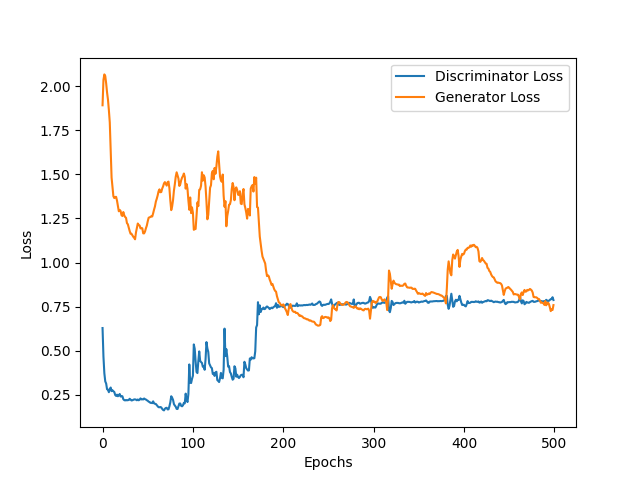

---


In [ ]:
num_generated_sequences = 5
generated_sequences = generate_sequences(generator, num_generated_sequences, latent_dim)

decoded = decode(generated_sequences)

for i, sequence in enumerate(decoded):
    print(sequence)

MTLRAQASDQARVYQAGRDLYVNE

MTLRAQASDQARVYQAGRDLYVNE

MTLRAQASDQARVYQAGRDLYVNE

MTLRAQASDQARVYQAGRDLYVNE

MTLRAQASDQARVYQAGRDLYVNE

---
One-hot encode the dataset and train the GAN model for 1000 epochs and no diveristy_weight.

In [ ]:
X_train = one_hot_encoding(X_data)

latent_dim = 100
output_dim = X_train.shape[1:]

generator = build_generator(latent_dim, output_dim)
discriminator = build_discriminator(X_train[0].shape)
gan = build_gan(generator, discriminator)

train_gan(generator, discriminator, gan, X_train, epochs=1000, diversity_weight=0.00)

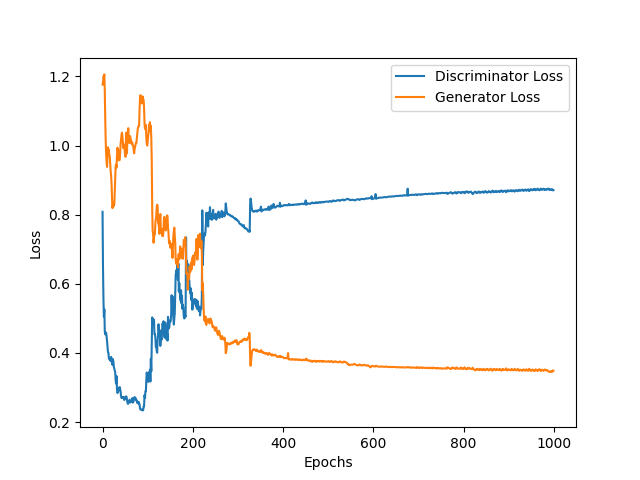

In [ ]:
num_generated_sequences = 5
generated_sequences = generate_sequences(generator, num_generated_sequences, latent_dim)

decoded = decode(generated_sequences)

for i, sequence in enumerate(decoded):
    print(sequence)

MTLRAQASDQARVYQAGRDLYVNE

MTLRAQASDQARVYQAGRDLYVNE

MTLRAQASDQARVYQAGRDLYVNE

MTLRAQASDQARVYQAGRDLYVNE

MTLRAQASDQARVYQAGRDLYVNE

---
One-hot encode the dataset and train the GAN model for 5000 epochs and no diveristy_weight.

In [ ]:
X_train = one_hot_encoding(X_data)

latent_dim = 100
output_dim = X_train.shape[1:]

generator = build_generator(latent_dim, output_dim)
discriminator = build_discriminator(X_train[0].shape)
gan = build_gan(generator, discriminator)

train_gan(generator, discriminator, gan, X_train, epochs=5000, diversity_weight=0.00)

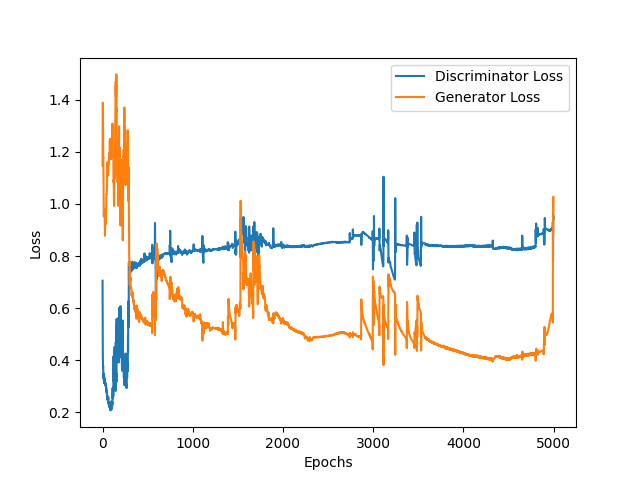

---
Generate and print sequences.

In [ ]:
num_generated_sequences = 5
generated_sequences = generate_sequences(generator, num_generated_sequences, latent_dim)

decoded = decode(generated_sequences)

for i, sequence in enumerate(decoded):
    print(sequence)

MTLRAQASDQARVYQAGRDLYVNE

MTLRAQASDQARVYQAGRDLYVNE

MTLRAQASDQARVYQAGRDLYVNE

MTLRAQASDQARVYQAGRDLYVNE

MTLRAQASDQARVYQAGRDLYVNE

---
One-hot encode the dataset and train the GAN model for 10000 epochs and no diveristy_weight.

In [ ]:
X_train = one_hot_encoding(X_data)

latent_dim = 100
output_dim = X_train.shape[1:]
generator = build_generator(latent_dim, output_dim)
discriminator = build_discriminator(X_train[0].shape)
gan = build_gan(generator, discriminator)

train_gan(generator, discriminator, gan, X_train, epochs=10000, diversity_weight=0.00)

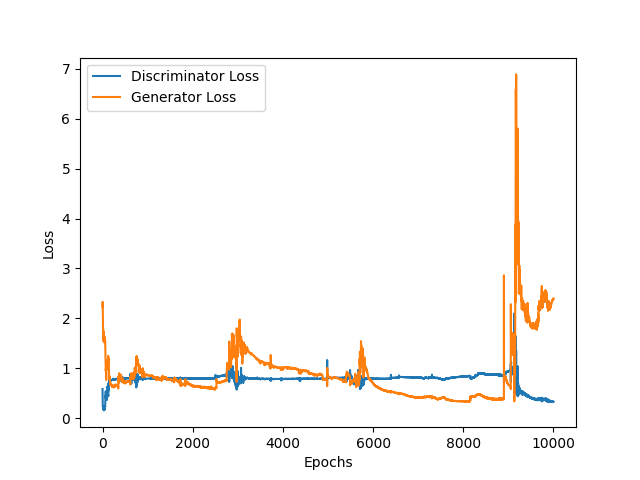

---
Generate and print sequences.

In [ ]:
num_generated_sequences = 5
generated_sequences = generate_sequences(generator, num_generated_sequences, latent_dim)

decoded = decode(generated_sequences)

for i, sequence in enumerate(decoded):
    print(sequence)

MTLRAQASDQARVYQAGRDLYVNE

MTLRAQASDQARVYQAGRDLYVNE

MTLRAQASDQARVYQAGRDLYVNE

MTLRAQASDQARVYQAGRDLYVNE

MTLRAQASDQARVYQAGRDLYVNE

---
One-hot encode the dataset and train the GAN model for 20000 epochs and no diveristy_weight.

In [ ]:
X_train = one_hot_encoding(X_data)

latent_dim = 100
output_dim = X_train.shape[1:]

generator = build_generator(latent_dim, output_dim)
discriminator = build_discriminator(X_train[0].shape)
gan = build_gan(generator, discriminator)

train_gan(generator, discriminator, gan, X_train, epochs=20000, diversity_weight=0.00)

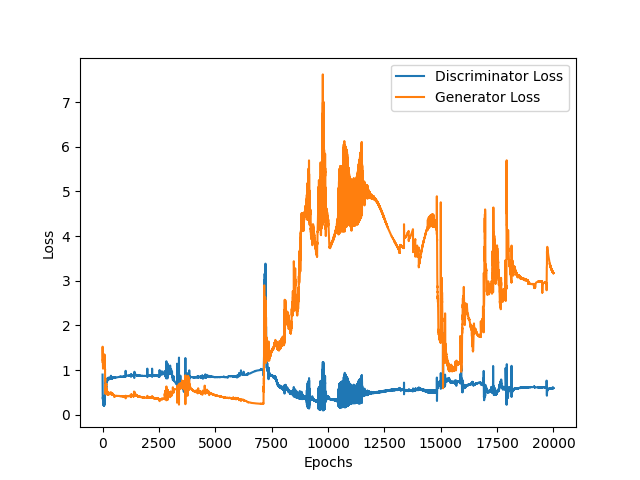

---
Generate and print sequences.

In [ ]:
num_generated_sequences = 5
generated_sequences = generate_sequences(generator, num_generated_sequences, latent_dim)

decoded = decode(generated_sequences)

for i, sequence in enumerate(decoded):
    print(sequence)

MTLRAQASDQARVYQAGRDLYVNE

MTLRAQASDQARVYQAGRDLYVNE

MTLRAQASDQARVYQAGRDLYVNE

MTLRAQASDQARVYQAGRDLYVNE

MTLRAQASDQARVYQAGRDLYVNE

---
One-hot encode the dataset and train the GAN model for 30000 epochs and no diveristy_weight.

In [ ]:
X_train = one_hot_encoding(X_data)

latent_dim = 100
output_dim = X_train.shape[1:]

generator = build_generator(latent_dim, output_dim)
discriminator = build_discriminator(X_train[0].shape)
gan = build_gan(generator, discriminator)

train_gan(generator, discriminator, gan, X_train, epochs=30000, diversity_weight=0.00)

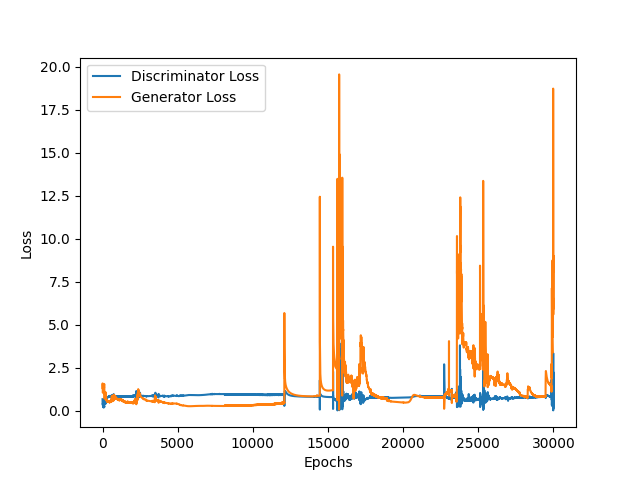

---
Generate and print sequences.

In [ ]:
num_generated_sequences = 5
generated_sequences = generate_sequences(generator, num_generated_sequences, latent_dim)

decoded = decode(generated_sequences)

for i, sequence in enumerate(decoded):
    print(sequence)

MTLRAQASDQARVYQAGRDLYVNE

MTLRAQASDQARVYQAGRDLYVNE

MTLRAQASDQARVYQAGRDLYVNE

MTLRAQASDQARVYQAGRDLYVNE

MTLRAQASDQARVYQAGRDLYVNE

---
One-hot encode the dataset and train the GAN model for 500 epochs and 0.01 diveristy_weight.

In [ ]:
X_train = one_hot_encoding(X_data)

latent_dim = 100
output_dim = X_train.shape[1:]  # Length of each sequence

generator = build_generator(latent_dim, output_dim)
discriminator = build_discriminator(X_train[0].shape)
gan = build_gan(generator, discriminator)

train_gan(generator, discriminator, gan, X_train, epochs=500, diversity_weight=0.01)

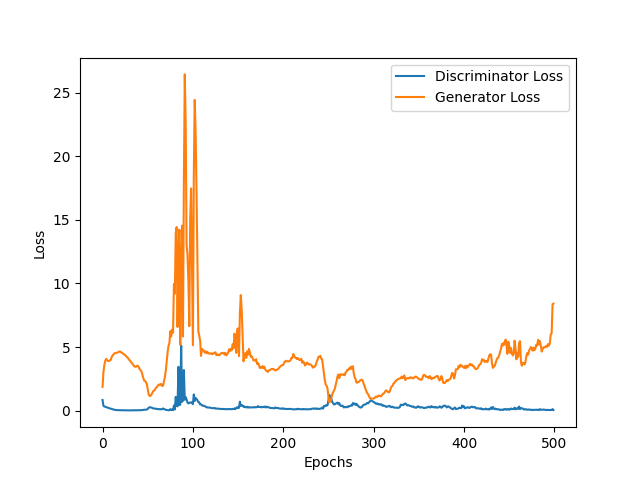

---
Generate and print sequences.

In [ ]:
num_generated_sequences = 5
generated_sequences = generate_sequences(generator, num_generated_sequences, latent_dim)

decoded = decode(generated_sequences)

for i, sequence in enumerate(decoded):
    print(sequence)

SEGESFRAGDVAVMTGITTQDLNHRGVGQGVNHNTFFYVTAEKLGRIVELYAGAELDALHAQALA

SEGESFRAGDVAVMTGITTQDLNHRGVVQGVNHNTFFYVTAEKLGRIVELEAGAELLPLHAQALA

SEGESFRAGDVAVMTGITTQDLNHRGVVQGVNHNTFFYVAAEKLGRIRELEAGAELDPLHAQGLA

SEGESFRAGDVAFMTGITTQDLNHRGVGQGVNHNTFFYVAAEKLGRIVELEAQAELDATHAQALA

SEGESFRAGDVQFMTGITTQDLNHRGVVGGVNHNTFFYVTAEKLPRGEEGEAQAELDATHAQALA

---
One-hot encode the dataset and train the GAN model for 1000 epochs and 0.01 diveristy_weight.

In [ ]:
X_train = one_hot_encoding(X_data)

latent_dim = 100
output_dim = X_train.shape[1:]  # Length of each sequence

generator = build_generator(latent_dim, output_dim)
discriminator = build_discriminator(X_train[0].shape)
gan = build_gan(generator, discriminator)

train_gan(generator, discriminator, gan, X_train, epochs=1000, diversity_weight=0.01)

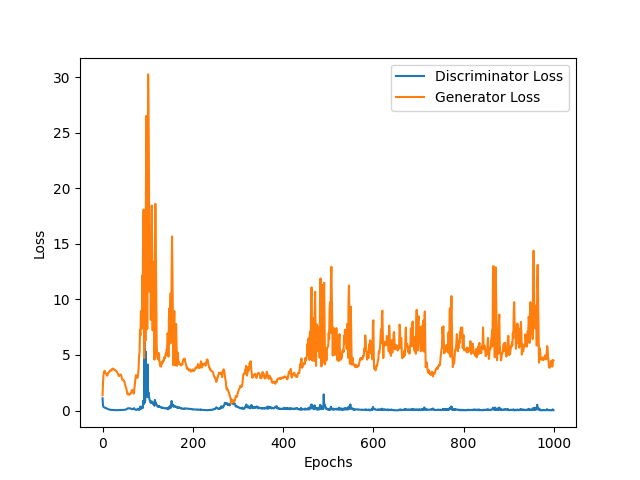

---
Generate and print sequences.

In [ ]:
num_generated_sequences = 5
generated_sequences = generate_sequences(generator, num_generated_sequences, latent_dim)

decoded = decode(generated_sequences)

for i, sequence in enumerate(decoded):
    print(sequence)

RNNAIITNVIFDGSHFTVGAVRSGVIQNIIHNTFPFNRVAEREEPAALRGAEWEGLARLRARALA

RNNAIITVVIFDGAHFTVMAVRSGVIQNGGHNTFPFNRVAEESLPAALRGAEWEGLARLRARALA

RNNAIITVVIFDGAHFTVGAVRSGVIQNQGHNTFPPRYVAERSAPAAVRGAEWEGLARLRARALA

RANRIIRVVIFDGQHFTVMDIISGLIQNQLVNLFPPRAVTERSGPAAERFAAGRGLARLHARALA

SNNAIITNQAFDGSHFTVGAVRSGVFQNIISNTFLANRVAEPSEGLALRGAEWEGLLRQRARALA

---
One-hot encode the dataset and train the GAN model for 5000 epochs and 0.01 diveristy_weight.

In [ ]:
X_train = one_hot_encoding(X_data)

latent_dim = 100
output_dim = X_train.shape[1:]  # Length of each sequence

generator = build_generator(latent_dim, output_dim)
discriminator = build_discriminator(X_train[0].shape)
gan = build_gan(generator, discriminator)

train_gan(generator, discriminator, gan, X_train, epochs=5000, diversity_weight=0.01)

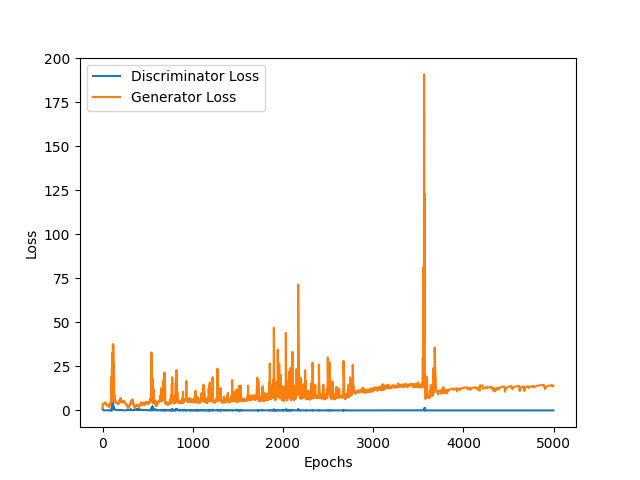

---
Generate and print sequences.

In [ ]:
num_generated_sequences = 5
generated_sequences = generate_sequences(generator, num_generated_sequences, latent_dim)

decoded = decode(generated_sequences)

for i, sequence in enumerate(decoded):
    print(sequence)

ATLFFDAAAATDAALAHAADIVNDTRQRGVWPLKEMQESHNVNYVSIVHSWASALEEEKFDHRAR

ATDFFDAAAAADAADAAAADIANADRQGGVWPHKEMQESNNVNYVSIVHSWADKLEEEKFDHRAR

ATEFFDAAAATDAALAAAADIENDTRQRGVWPHKEMQESHNVNYVSIVHSWASAGEEEKFDHRAY

ATEFFDAAAATDAALAAAADIGNDTRQRGVWPHKEMNESHNVNPVSIVHSWAFAGEEEKFDHRAY

ATEFFDAAAATDAALAAAADIGNDTRQRGVWPHKEMQESHNVNYVSIVHSWAFAGEEEKFDHRAR

---
One-hot encode the dataset and train the GAN model for 10000 epochs and 0.01 diveristy_weight.

In [ ]:
X_train = one_hot_encoding(X_data)

latent_dim = 100
output_dim = X_train.shape[1:]  # Length of each sequence

generator = build_generator(latent_dim, output_dim)
discriminator = build_discriminator(X_train[0].shape)
gan = build_gan(generator, discriminator)

train_gan(generator, discriminator, gan, X_train, epochs=10000, diversity_weight=0.01)

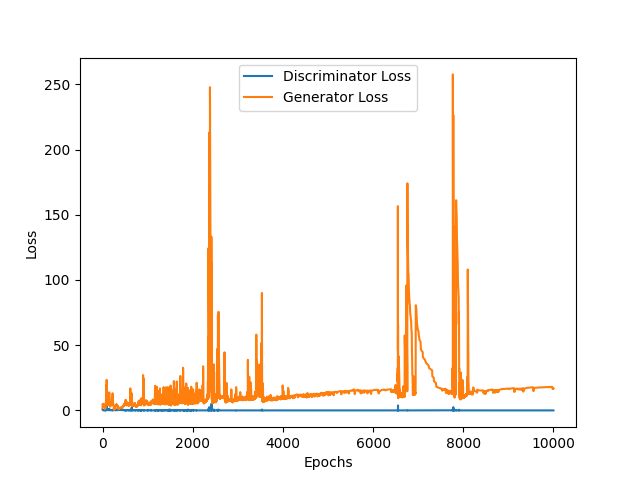

---
Generate and print sequences.

In [ ]:
num_generated_sequences = 5
generated_sequences = generate_sequences(generator, num_generated_sequences, latent_dim)

decoded = decode(generated_sequences)

for i, sequence in enumerate(decoded):
    print(sequence)

GFWAIPHVNVNYTSNGIMRKRGSHYENFFYRPTQKQQLFRYHAPDHSEEPQLQYGGTSEVNFPEI

GFWAIPHVNVNYTSNGIMRKRGSHGENFFYRPTSKQQLFRYHAPDHSEEPQLQYGGTSESNFPEI

GFWAIPHVNVNYTSNGIMRKRGSHYENFFYRPTSKQQLFRYHAPDHSEEPQLQYGGTSEVYFPEI

GFWAIPHVNVNYTSNRIMRKRGSHYENFFYRPTSKQQLFRYHAPDHSEEPQLQYGGTSEVNFPEI

GFWAIPHVNVNYTSNRIMRKRGQHYEHFFYRPTQQQQLFRYHAPDHSEEPQLQYGGTSEVNFPEI